🎲 Random state used for this run: 42

COLLECTING FILES
Z (NORMAL): 100 files
O (NORMAL): 100 files
N (INTERICTAL): 100 files
F (INTERICTAL): 100 files
S (ICTAL): 100 files

Total files: 500
Class distribution: (array(['ICTAL', 'INTERICTAL', 'NORMAL'], dtype='<U10'), array([100, 200, 200]))

CREATING 5-FOLD SPLIT ON FILES (Before Segmentation)

Fold 1:
  Train files: 400
  Test files:  100
  Train classes: (array(['ICTAL', 'INTERICTAL', 'NORMAL'], dtype='<U10'), array([ 80, 163, 157]))
  Test classes:  (array(['ICTAL', 'INTERICTAL', 'NORMAL'], dtype='<U10'), array([20, 37, 43]))

Fold 2:
  Train files: 400
  Test files:  100
  Train classes: (array(['ICTAL', 'INTERICTAL', 'NORMAL'], dtype='<U10'), array([ 80, 166, 154]))
  Test classes:  (array(['ICTAL', 'INTERICTAL', 'NORMAL'], dtype='<U10'), array([20, 34, 46]))

Fold 3:
  Train files: 400
  Test files:  100
  Train classes: (array(['ICTAL', 'INTERICTAL', 'NORMAL'], dtype='<U10'), array([ 80, 155, 165]))
  Test classes:  (array(['ICTA

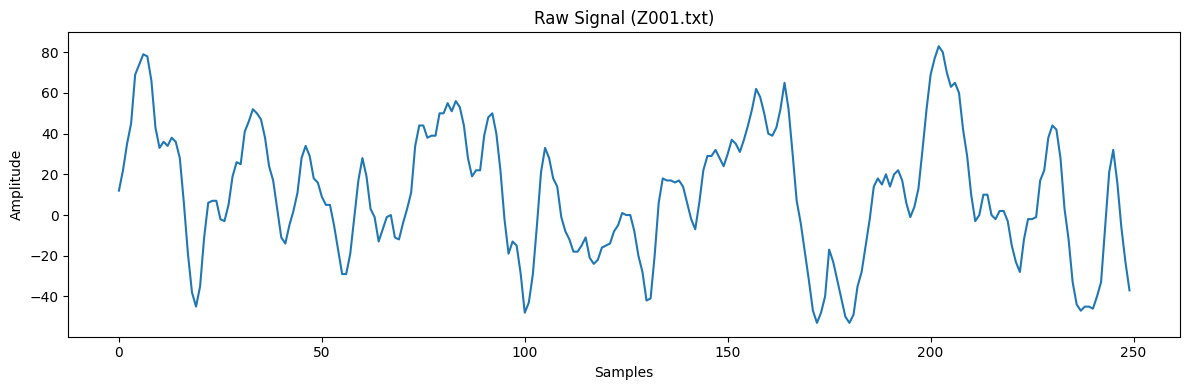

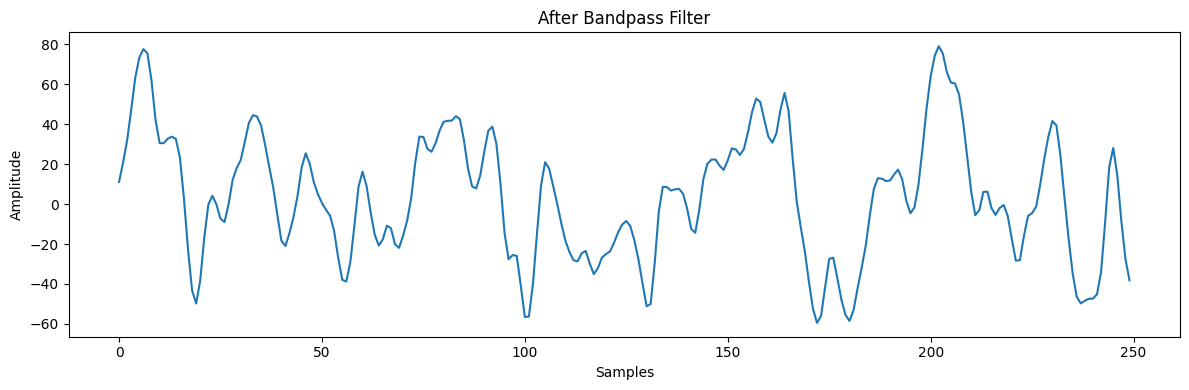

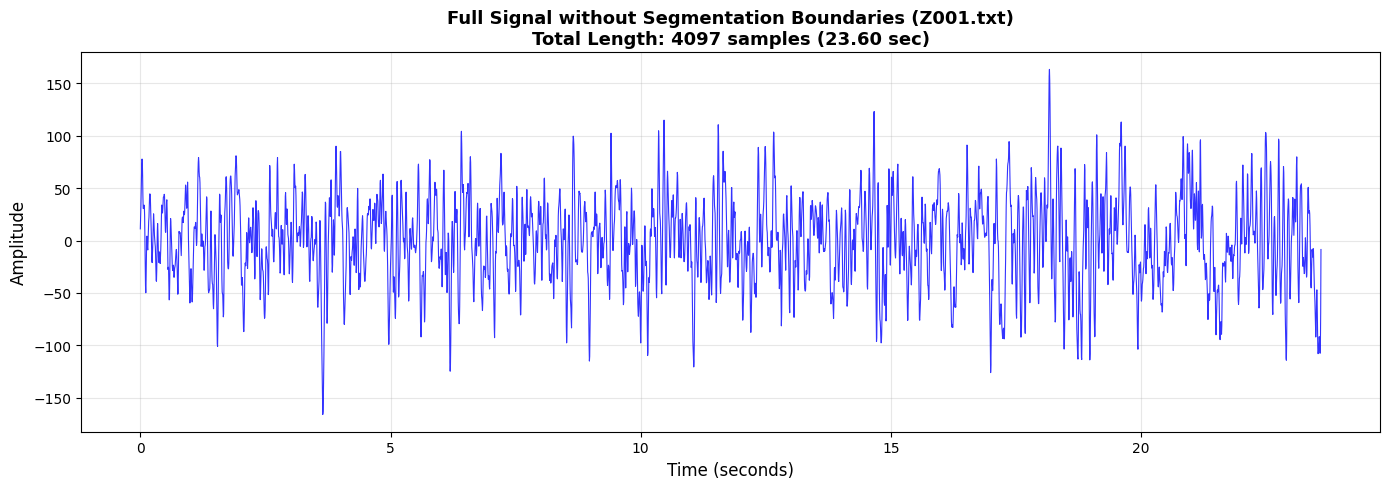

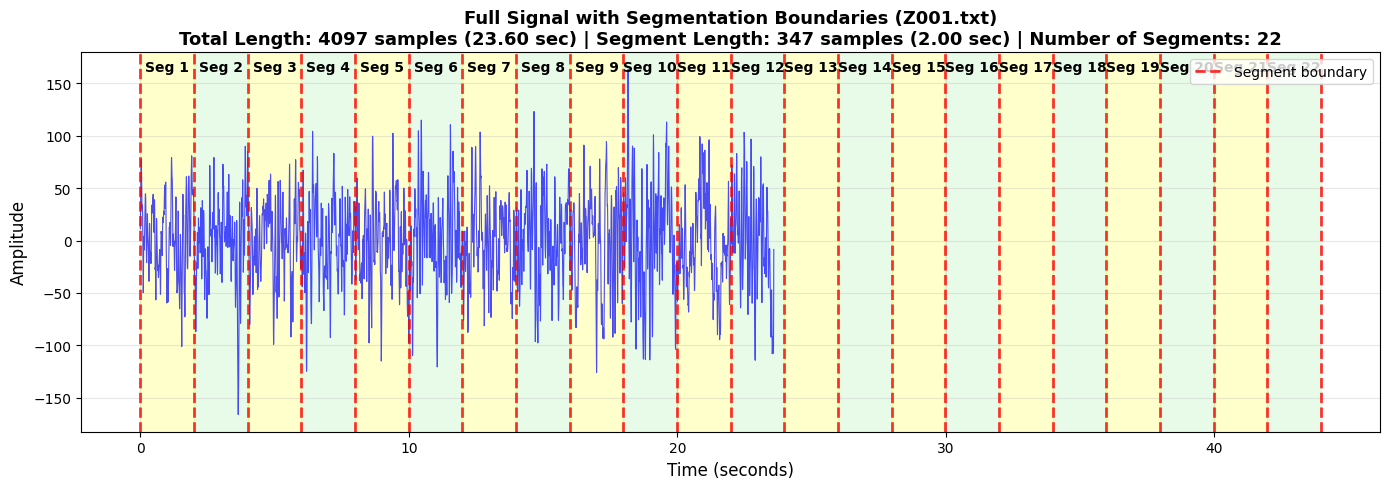

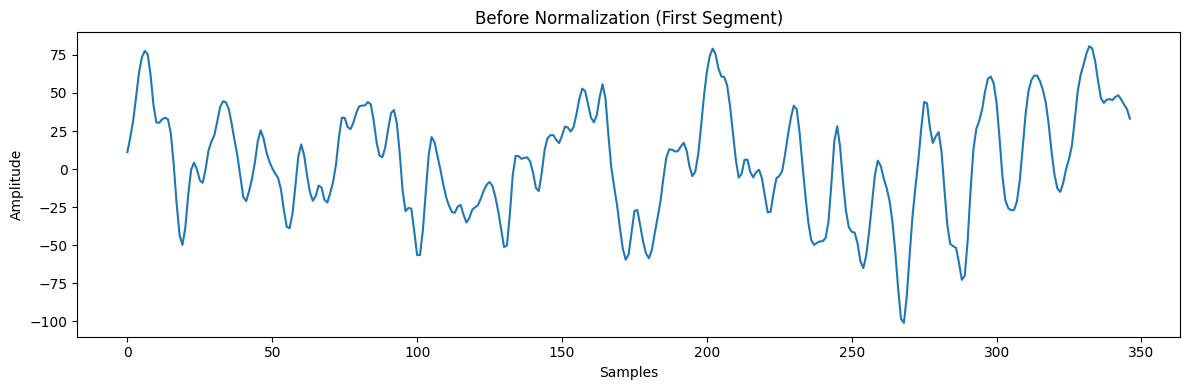

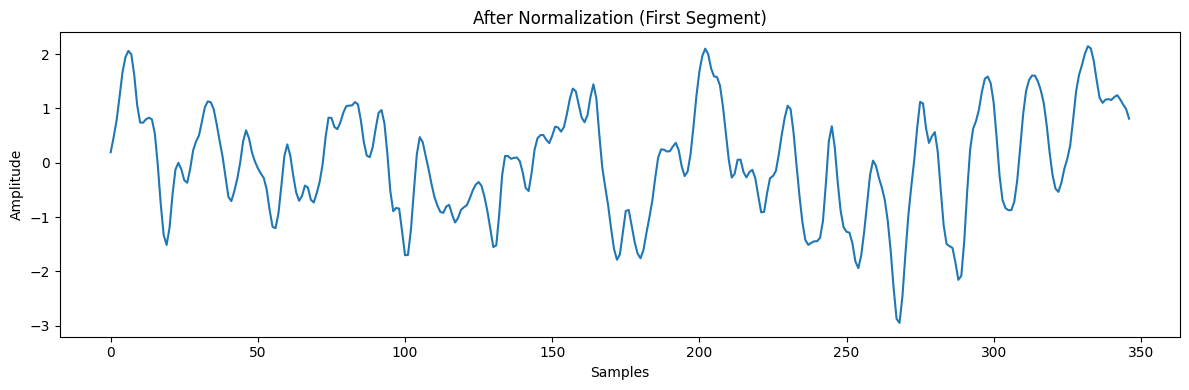

  Fold 1 TRAIN: 8800 segments from 400 files
  Fold 1 TEST: 2200 segments from 100 files
  ✅ Saved Fold 1 training data: (8800, 347)
  ✅ Saved Fold 1 test data: (2200, 347)

FOLD 2
  Fold 2 TRAIN: 8800 segments from 400 files
  Fold 2 TEST: 2200 segments from 100 files
  ✅ Saved Fold 2 training data: (8800, 347)
  ✅ Saved Fold 2 test data: (2200, 347)

FOLD 3
  Fold 3 TRAIN: 8800 segments from 400 files
  Fold 3 TEST: 2200 segments from 100 files
  ✅ Saved Fold 3 training data: (8800, 347)
  ✅ Saved Fold 3 test data: (2200, 347)

FOLD 4
  Fold 4 TRAIN: 8800 segments from 400 files
  Fold 4 TEST: 2200 segments from 100 files
  ✅ Saved Fold 4 training data: (8800, 347)
  ✅ Saved Fold 4 test data: (2200, 347)

FOLD 5
  Fold 5 TRAIN: 8800 segments from 400 files
  Fold 5 TEST: 2200 segments from 100 files
  ✅ Saved Fold 5 training data: (8800, 347)
  ✅ Saved Fold 5 test data: (2200, 347)

VERIFICATION: No Data Leakage Between Folds
Fold 1: Train files=400, Test files=100, Overlap=0
Fold 2:

In [3]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.model_selection import StratifiedKFold

# Bandpass Filter
def bandpass_filter(data, lowcut=0.5, highcut=40, fs=173.61, order=5):
    nyquist = 0.5 * fs
    low, high = lowcut / nyquist, highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Preprocessing Function
def preprocess_signal(signal, fs=173.61, segment_length=None):
    # Bandpass Filter
    filtered = bandpass_filter(signal, 0.5, 50, fs)

    # Segmentation WITH OVERLAP
    if segment_length is None:
        segment_length = int(2 * fs)  # 2-second segments
    
    step_size = int(segment_length * (1 - 0.5))  # 50% overlap
    
    segments = []
    for start in range(0, len(filtered) - segment_length + 1, step_size):
        end = start + segment_length
        segments.append(filtered[start:end])
    
    segments = np.array(segments)

    # ✅ Z-score normalization (per segment)
    normed_segments = np.zeros_like(segments)
    for i in range(segments.shape[0]):
        mean = segments[i].mean()
        std = segments[i].std()
        if std > 0:
            normed_segments[i] = (segments[i] - mean) / std
        else:
            normed_segments[i] = segments[i] - mean

    return normed_segments, filtered, segments


def plot_segmentation_detailed(filtered, segments, fs=173.61, segment_length=None, filename=""):
    if segment_length is None:
        segment_length = int(2 * fs)
    
    num_segments = len(segments)
    fig, ax = plt.subplots(figsize=(14, 5))
    time = np.arange(len(filtered)) / fs
    ax.plot(time, filtered, 'b-', linewidth=0.8, alpha=0.7)
    
    for i in range(num_segments + 1):
        segment_time = i * segment_length / fs
        ax.axvline(x=segment_time, color='red', linestyle='--', 
                   linewidth=2, alpha=0.8, label='Segment boundary' if i == 0 else '')
    
    for i in range(num_segments):
        start_time = i * segment_length / fs
        end_time = (i + 1) * segment_length / fs
        color = 'yellow' if i % 2 == 0 else 'lightgreen'
        ax.axvspan(start_time, end_time, alpha=0.2, color=color)
        mid_time = (start_time + end_time) / 2
        ax.text(mid_time, ax.get_ylim()[1] * 0.9, f'Seg {i+1}', 
                ha='center', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_ylabel('Amplitude', fontsize=12)
    
    title = f'Full Signal with Segmentation Boundaries'
    if filename:
        title += f' ({filename})'
    title += f'\nTotal Length: {len(filtered)} samples ({len(filtered)/fs:.2f} sec) | '
    title += f'Segment Length: {segment_length} samples ({segment_length/fs:.2f} sec) | '
    title += f'Number of Segments: {num_segments}'
    
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# ==================== FIXED: Load & Preprocess with 5-Fold Split ====================
def load_and_preprocess_bonn_kfold(root_dir, save_dir, n_splits=5, random_state=None, plot_example=True):
    """
    Fixed version that creates 5-fold splits on FILES first, then segments each fold
    
    Args:
        root_dir: Root directory containing Z, O, N, F, S folders
        save_dir: Directory to save preprocessed fold data
        n_splits: Number of folds (default: 5)
        random_state: Random seed for reproducibility
        plot_example: Whether to plot preprocessing steps
    """
    
    if random_state is None:
        random_state = np.random.randint(0, 10000)
    
    print(f"🎲 Random state used for this run: {random_state}")
    
    # Map folders to classes
    classes = {
        "Z": "NORMAL",
        "O": "NORMAL",
        "N": "INTERICTAL",
        "F": "INTERICTAL",
        "S": "ICTAL"
    }

    # ==================== STEP 1: Collect all file paths with their labels ====================
    all_files = []
    all_file_labels = []
    
    print("\n" + "="*70)
    print("COLLECTING FILES")
    print("="*70)
    
    for folder, label in classes.items():
        folder_path = os.path.join(root_dir, folder)
        files = glob.glob(os.path.join(folder_path, "**", "*.txt"), recursive=True)
        
        all_files.extend(files)
        all_file_labels.extend([label] * len(files))
        
        print(f"{folder} ({label}): {len(files)} files")
    
    all_files = np.array(all_files)
    all_file_labels = np.array(all_file_labels)
    
    print(f"\nTotal files: {len(all_files)}")
    print(f"Class distribution: {np.unique(all_file_labels, return_counts=True)}")

    # ==================== STEP 2: Create 5-fold split on FILES ====================
    print("\n" + "="*70)
    print("CREATING 5-FOLD SPLIT ON FILES (Before Segmentation)")
    print("="*70)
    
    # For stratification, convert labels to binary for ICTAL vs Others
    file_labels_binary = np.where(all_file_labels == 'ICTAL', 0, 1)
    
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    fold_file_indices = list(kfold.split(all_files, file_labels_binary))
    
    # Save fold indices
    os.makedirs(save_dir, exist_ok=True)
    np.save(os.path.join(save_dir, "fold_file_indices.npy"), 
            np.array(fold_file_indices, dtype=object), allow_pickle=True)
    
    for fold_no, (train_idx, test_idx) in enumerate(fold_file_indices, start=1):
        train_files = all_files[train_idx]
        test_files = all_files[test_idx]
        train_labels = all_file_labels[train_idx]
        test_labels = all_file_labels[test_idx]
        
        print(f"\nFold {fold_no}:")
        print(f"  Train files: {len(train_files)}")
        print(f"  Test files:  {len(test_files)}")
        print(f"  Train classes: {np.unique(train_labels, return_counts=True)}")
        print(f"  Test classes:  {np.unique(test_labels, return_counts=True)}")

    # ==================== STEP 3: Process each fold separately ====================
    def process_fold_files(files, labels, fold_no, split_name, plot=False):
        """Process files and create segments for a specific fold"""
        all_segments = []
        all_segment_labels = []
        plotted = False
        
        for file_path, label in zip(files, labels):
            try:
                data = np.loadtxt(file_path)
                normed_segments, filtered, segments = preprocess_signal(data)
                
                # Plot one example (only once)
                if plot and not plotted:
                    print(f"\n📊 Plotting example from {os.path.basename(file_path)}")
                    
                    # 1. Raw Signal
                    plt.figure(figsize=(12, 4))
                    plt.plot(data[:250])
                    plt.title(f"Raw Signal ({os.path.basename(file_path)})")
                    plt.xlabel("Samples")
                    plt.ylabel("Amplitude")
                    plt.tight_layout()
                    plt.show()

                    # 2. After Bandpass Filter
                    plt.figure(figsize=(12, 4))
                    plt.plot(filtered[:250])
                    plt.title("After Bandpass Filter")
                    plt.xlabel("Samples")
                    plt.ylabel("Amplitude")
                    plt.tight_layout()
                    plt.show()

                    # 3. Full Filtered Signal
                    plt.figure(figsize=(14, 5))
                    time_full = np.arange(len(filtered)) / 173.61
                    plt.plot(time_full, filtered, 'b-', linewidth=0.8, alpha=0.8)
                    plt.xlabel('Time (seconds)', fontsize=12)
                    plt.ylabel('Amplitude', fontsize=12)
                    plt.title(f'Full Signal without Segmentation Boundaries ({os.path.basename(file_path)})\n' +
                             f'Total Length: {len(filtered)} samples ({len(filtered)/173.61:.2f} sec)',
                             fontsize=13, fontweight='bold')
                    plt.grid(True, alpha=0.3)
                    plt.tight_layout()
                    plt.show()

                    # 4. Segmentation Visualization
                    plot_segmentation_detailed(filtered, segments, 
                                             fs=173.61, 
                                             segment_length=int(2*173.61),
                                             filename=os.path.basename(file_path))

                    # 5. Before Normalization
                    plt.figure(figsize=(12, 4))
                    plt.plot(segments[0])
                    plt.title("Before Normalization (First Segment)")
                    plt.xlabel("Samples")
                    plt.ylabel("Amplitude")
                    plt.tight_layout()
                    plt.show()
                    
                    # 6. After Normalization
                    plt.figure(figsize=(12, 4))
                    plt.plot(normed_segments[0])
                    plt.title("After Normalization (First Segment)")
                    plt.xlabel("Samples")
                    plt.ylabel("Amplitude")
                    plt.tight_layout()
                    plt.show()
                    
                    plotted = True
                
                # Add all segments from this file
                all_segments.append(normed_segments)
                all_segment_labels.extend([label] * len(normed_segments))
                
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
        
        if all_segments:
            X = np.vstack(all_segments)
            y = np.array(all_segment_labels)
            print(f"  Fold {fold_no} {split_name}: {X.shape[0]} segments from {len(files)} files")
            return X, y
        return None, None

    # Process all folds
    print("\n" + "="*70)
    print("PROCESSING ALL FOLDS")
    print("="*70)
    
    for fold_no, (train_idx, test_idx) in enumerate(fold_file_indices, start=1):
        print(f"\n{'='*70}")
        print(f"FOLD {fold_no}")
        print(f"{'='*70}")
        
        train_files = all_files[train_idx]
        test_files = all_files[test_idx]
        train_file_labels = all_file_labels[train_idx]
        test_file_labels = all_file_labels[test_idx]
        
        # Process training files
        X_train, y_train = process_fold_files(
            train_files, train_file_labels, fold_no, "TRAIN", 
            plot=(plot_example and fold_no == 1)
        )
        
        # Process test files
        X_test, y_test = process_fold_files(
            test_files, test_file_labels, fold_no, "TEST", 
            plot=False
        )
        
        # Save fold data
        if X_train is not None:
            np.save(os.path.join(save_dir, f"fold{fold_no}_train_X.npy"), X_train)
            np.save(os.path.join(save_dir, f"fold{fold_no}_train_y.npy"), y_train)
            print(f"  ✅ Saved Fold {fold_no} training data: {X_train.shape}")
        
        if X_test is not None:
            np.save(os.path.join(save_dir, f"fold{fold_no}_test_X.npy"), X_test)
            np.save(os.path.join(save_dir, f"fold{fold_no}_test_y.npy"), y_test)
            print(f"  ✅ Saved Fold {fold_no} test data: {X_test.shape}")

    # ==================== VERIFICATION ====================
    print("\n" + "="*70)
    print("VERIFICATION: No Data Leakage Between Folds")
    print("="*70)
    
    # Check that files don't overlap between folds
    for fold_no, (train_idx, test_idx) in enumerate(fold_file_indices, start=1):
        train_set = set(all_files[train_idx])
        test_set = set(all_files[test_idx])
        overlap = train_set.intersection(test_set)
        print(f"Fold {fold_no}: Train files={len(train_set)}, Test files={len(test_set)}, Overlap={len(overlap)}")
        assert len(overlap) == 0, f"❌ Found overlap in Fold {fold_no}!"
    
    print("\n✅ All folds verified: No file overlap between train/test!")
    print("✅ Files split BEFORE segmentation - No data leakage!")

    return fold_file_indices


# Main
if __name__ == "__main__":
    root = r"C:\Users\Mostafa\Documents\gp\GP-Epileptic-seizures"
    save_dir = os.path.join(root, "preprocessed_5fold")

    fold_indices = load_and_preprocess_bonn_kfold(
        root, save_dir, n_splits=5, random_state=42, plot_example=True
    )
    
    print("\n" + "="*70)
    print("PREPROCESSING COMPLETE!")
    print("="*70)
    print(f"✅ 5 folds created and saved to: {save_dir}")
    print(f"✅ Each fold has separate train/test files")
    print(f"✅ No data leakage between folds")